In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/home/ra/Codes/multilang_timescale


In [25]:
import json 

import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.plot import config_plotting, figsize_dict, create_discrete_cmap
from src.utils.meta import read_result_meta
from src.utils.utils import get_valid_voxels
from src.utils.weight import process_primal_weight
from src.settings import TrainerSetting

In [71]:
config_plotting('paper')
# get default font size
default_font_size = plt.rcParams['font.size']

In [6]:
image_dir = ".temp/image/semantic_cluster/"

result_metric = "r2"    
result_meta_dir = ".temp/result_meta/bling"
alpha = 0.05

cluster_centroids_file = ".temp/misc/semantic_cluster/cluster_centroids_bling.npy"

In [7]:
subject_ids = ['COL', 'GFW', 'TYE']

In [8]:
def load_semantic_weight_data(subject_id):
    subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
    subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

    feature_file_en = f".temp/config/bling/feature/{subject_id}/fasttext_stepwise_en.json"
    feature_file_zh = f".temp/config/bling/feature/{subject_id}/fasttext_stepwise_zh.json"

    trainer_en_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en-save_primal.json"
    )
    trainer_zh_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh-save_primal.json"
    )
    # loading semantic vem

    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_en_file,
        subject_setting_path=subject_file_en,
        feature_setting_path=feature_file_en,
    )
    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_zh_file,
        subject_setting_path=subject_file_zh,
        feature_setting_path=feature_file_zh,
    )
        
    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()

    en_stat = en_config["stats_path"]
    en_stat = np.load(en_stat)

    zh_stat = zh_config["stats_path"]
    zh_stat = np.load(zh_stat)

    valid_en_voxel_mask, valid_en_voxel_idx = get_valid_voxels(en_stat, metric=result_metric, alpha=alpha)
    valid_zh_voxel_mask, valid_zh_voxel_idx = get_valid_voxels(zh_stat, metric=result_metric, alpha=alpha)


    en_joint_pred_acc = en_stat[f"test_joint_{result_metric}_score_mask"]
    zh_joint_pred_acc = zh_stat[f"test_joint_{result_metric}_score_mask"]

    # get sqrt
    if result_metric == 'r2':
        en_joint_pred_acc = np.sqrt(en_joint_pred_acc)
        zh_joint_pred_acc = np.sqrt(zh_joint_pred_acc)

    return {
        'en': {
            'config': en_config,
            'stat': en_stat,
            'valid_voxel_mask': valid_en_voxel_mask,
            'valid_voxel_idx': valid_en_voxel_idx,
            'joint_pred_acc': en_joint_pred_acc
        },
        'zh': {
            'config': zh_config,
            'stat': zh_stat,
            'valid_voxel_mask': valid_zh_voxel_mask,
            'valid_voxel_idx': valid_zh_voxel_idx,
            'joint_pred_acc': zh_joint_pred_acc
        }
    }

In [9]:
def load_timescale_data(subject_id):
    subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
    subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

    trainer_en_ts_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    )

    trainer_zh_ts_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"
    )

    feature_file_en_ts = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    feature_file_zh_ts = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"

    # loading timescale vem
    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_en_ts_file,
        subject_setting_path=subject_file_en,
        feature_setting_path=feature_file_en_ts,)

    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_zh_ts_file,
        subject_setting_path=subject_file_zh,
        feature_setting_path=feature_file_zh_ts,
    )

    # load trainer json file to TrainerSetting
    en_ts_config = en_meta_df.iloc[0].to_dict()
    zh_ts_config = zh_meta_df.iloc[0].to_dict()
        
    en_ts_stat = en_ts_config["stats_path"]
    en_ts_stat = np.load(en_ts_stat)

    zh_ts_stat = zh_ts_config["stats_path"]
    zh_ts_stat = np.load(zh_ts_stat)

    valid_en_ts_voxel_mask, valid_en_ts_voxel_idx = get_valid_voxels(en_ts_stat, metric=result_metric, alpha=alpha)
    valid_zh_ts_voxel_mask, valid_zh_ts_voxel_idx = get_valid_voxels(zh_ts_stat, metric=result_metric, alpha=alpha)

    en_timescale = en_ts_stat[f"test_{result_metric}_selectivity_mask"]
    zh_timescale = zh_ts_stat[f"test_{result_metric}_selectivity_mask"]

    return {
        'en': en_timescale,
        'zh': zh_timescale,

        'en_valid_idx': valid_en_ts_voxel_idx,
        'zh_valid_idx': valid_zh_ts_voxel_idx,
    }

In [10]:
def get_primal_weight(semantic_weight_data):
    en_primal_weight = semantic_weight_data['en']['config']['primal_weights_path']
    zh_primal_weight = semantic_weight_data['zh']['config']['primal_weights_path']

    en_primal_weight = np.load(en_primal_weight)['primal_weights']    
    zh_primal_weight = np.load(zh_primal_weight)['primal_weights']

    en_primal_weight = np.squeeze(en_primal_weight)
    zh_primal_weight = np.squeeze(zh_primal_weight)

    en_primal_weight = process_primal_weight(en_primal_weight, prediction_score=semantic_weight_data['en']['joint_pred_acc'], normalize=True)
    zh_primal_weight = process_primal_weight(zh_primal_weight, prediction_score=semantic_weight_data['zh']['joint_pred_acc'], normalize=True)

    return {
        'en': en_primal_weight,
        'zh': zh_primal_weight
    } 

In [11]:
timescales = {}
for subject_id in subject_ids:
    timescales[subject_id] = load_timescale_data(subject_id)

In [12]:
semantic_maps = {}
for subject_id in subject_ids:
    semantic_maps[subject_id] = load_semantic_weight_data(subject_id)

/tmp/ipykernel_1124272/1613024286.py:47: RuntimeWarning: invalid value encountered in sqrt
  en_joint_pred_acc = np.sqrt(en_joint_pred_acc)
/tmp/ipykernel_1124272/1613024286.py:48: RuntimeWarning: invalid value encountered in sqrt
  zh_joint_pred_acc = np.sqrt(zh_joint_pred_acc)
/tmp/ipykernel_1124272/1613024286.py:47: RuntimeWarning: invalid value encountered in sqrt
  en_joint_pred_acc = np.sqrt(en_joint_pred_acc)
/tmp/ipykernel_1124272/1613024286.py:48: RuntimeWarning: invalid value encountered in sqrt
  zh_joint_pred_acc = np.sqrt(zh_joint_pred_acc)
/tmp/ipykernel_1124272/1613024286.py:47: RuntimeWarning: invalid value encountered in sqrt
  en_joint_pred_acc = np.sqrt(en_joint_pred_acc)
/tmp/ipykernel_1124272/1613024286.py:48: RuntimeWarning: invalid value encountered in sqrt
  zh_joint_pred_acc = np.sqrt(zh_joint_pred_acc)


In [13]:
primal_weights = {}
for subject_id in subject_ids:
    primal_weights[subject_id] = get_primal_weight(semantic_maps[subject_id])

In [14]:
# loading fasttext embeddings
centroids = np.load(cluster_centroids_file)

en_fasttext = ".temp/misc/word_list/en_fasttext_embeddings.npy"
zh_fasttext = ".temp/misc/word_list/zh_fasttext_embeddings.npy"

en_fasttext = np.load(en_fasttext, allow_pickle=True).tolist()
zh_fasttext = np.load(zh_fasttext, allow_pickle=True).tolist()

en_words = list(en_fasttext.keys())
zh_words = list(zh_fasttext.keys())

# get word from en_words and zh_words
en_words = np.array(en_words)
zh_words = np.array(zh_words)

# now get all value from en_fasttext dictionary and project that to pca
en_fasttext_values = np.array(list(en_fasttext.values()))
zh_fasttext_values = np.array(list(zh_fasttext.values()))


In [15]:
def cluster_weights(primal_weight, centroids):
    def cluster(x, centroids):
        return np.argmin(np.linalg.norm(x - centroids, axis=1))
    
    en_cluster = np.array([cluster(x, centroids) for x in primal_weight['en']])
    zh_cluster = np.array([cluster(x, centroids) for x in primal_weight['zh']])

    return {
        'en': en_cluster,
        'zh': zh_cluster
    }

In [16]:
clustered_weights = {}
for subject_id in subject_ids:
    clustered_weights[subject_id] = cluster_weights(primal_weights[subject_id], centroids)

In [17]:
np.nanmax(clustered_weights['COL']['en'])

4

In [18]:
def get_timescale_per_cluster(clustered_weight, timescale, semantic_map, n_clusters = 5, join_mode='all'):
    en_cluster_voxels = clustered_weight['en']
    zh_cluster_voxels = clustered_weight['zh']

    en_timescale = timescale['en']
    zh_timescale = timescale['zh']

    en_semantic_valid_idx = semantic_map['en']['valid_voxel_idx']
    zh_semantic_valid_idx = semantic_map['zh']['valid_voxel_idx']

    en_timescale_valid_idx = timescale['en_valid_idx']
    zh_timescale_valid_idx = timescale['zh_valid_idx']
    
    if join_mode == 'all':
        joint_valid_idx = np.intersect1d(en_semantic_valid_idx, zh_semantic_valid_idx)
        joint_valid_idx = np.intersect1d(joint_valid_idx, en_timescale_valid_idx)
        joint_valid_idx = np.intersect1d(joint_valid_idx, zh_timescale_valid_idx)

        en_valid_idx = joint_valid_idx
        zh_valid_idx = joint_valid_idx
    else:
        en_valid_idx = np.intersect1d(en_semantic_valid_idx, en_timescale_valid_idx)
        zh_valid_idx = np.intersect1d(zh_semantic_valid_idx, zh_timescale_valid_idx)
    
    timescale_per_cluster = {}

    for i in range(n_clusters):
        en_cluster_idx = np.where(en_cluster_voxels == i)[0]
        zh_cluster_idx = np.where(zh_cluster_voxels == i)[0]

        joint_en_idx = np.intersect1d(en_cluster_idx, en_valid_idx)
        joint_zh_idx = np.intersect1d(zh_cluster_idx, zh_valid_idx)

        en_cluster_timescale = en_timescale[joint_en_idx]
        zh_cluster_timescale = zh_timescale[joint_zh_idx]

        timescale_per_cluster[i] = {
            'en': en_cluster_timescale,
            'zh': zh_cluster_timescale
        }
    
    return timescale_per_cluster

In [19]:
timescales_per_clusters = {}

for subject_id in subject_ids:
    timescales_per_clusters[subject_id] = get_timescale_per_cluster(
        clustered_weights[subject_id], timescales[subject_id], semantic_maps[subject_id], n_clusters=5, join_mode='lang')

In [66]:
def plot_histograms(timescales_per_clusters, subject_id, axs = None, cmap='hls', plot_xlabel=False, plot_ylabel=False):
    cmap = create_discrete_cmap(5, palette=cmap)

    if axs is None:
        fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True,)
    # share x axis

    for i in range(5):
        en_timescale = timescales_per_clusters[subject_id][i]['en']
        zh_timescale = timescales_per_clusters[subject_id][i]['zh']

        # plot en zh but different line style
        sns.kdeplot(en_timescale, ax=axs[i], label='en', color=cmap(i), linestyle='--')
        sns.kdeplot(zh_timescale, ax=axs[i], label='zh', color=cmap(i), linestyle='-')   
        
        
        axs[i].set_xlim(8, 256)
    
    # remove xticks for all but last
    for i in range(4):
        axs[i].set_xticklabels([])
    for i in range(5):
        axs[i].set_ylabel('')
    
    # remove y label for all but the middle
    if plot_ylabel:
        for i in range(5):
            if i != 2:
                axs[i].set_ylabel('')
            else:
                axs[i].set_ylabel('Density')
    
    # set subject id as title for first plot
    axs[0].set_title(subject_id)

    if plot_xlabel:
        axs[4].set_xlabel('Timescale Selectivity (words)')
    
    return axs

/tmp/ipykernel_1124272/1266702289.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(en_timescale, ax=axs[i], label='en', color=cmap(i), linestyle='--')


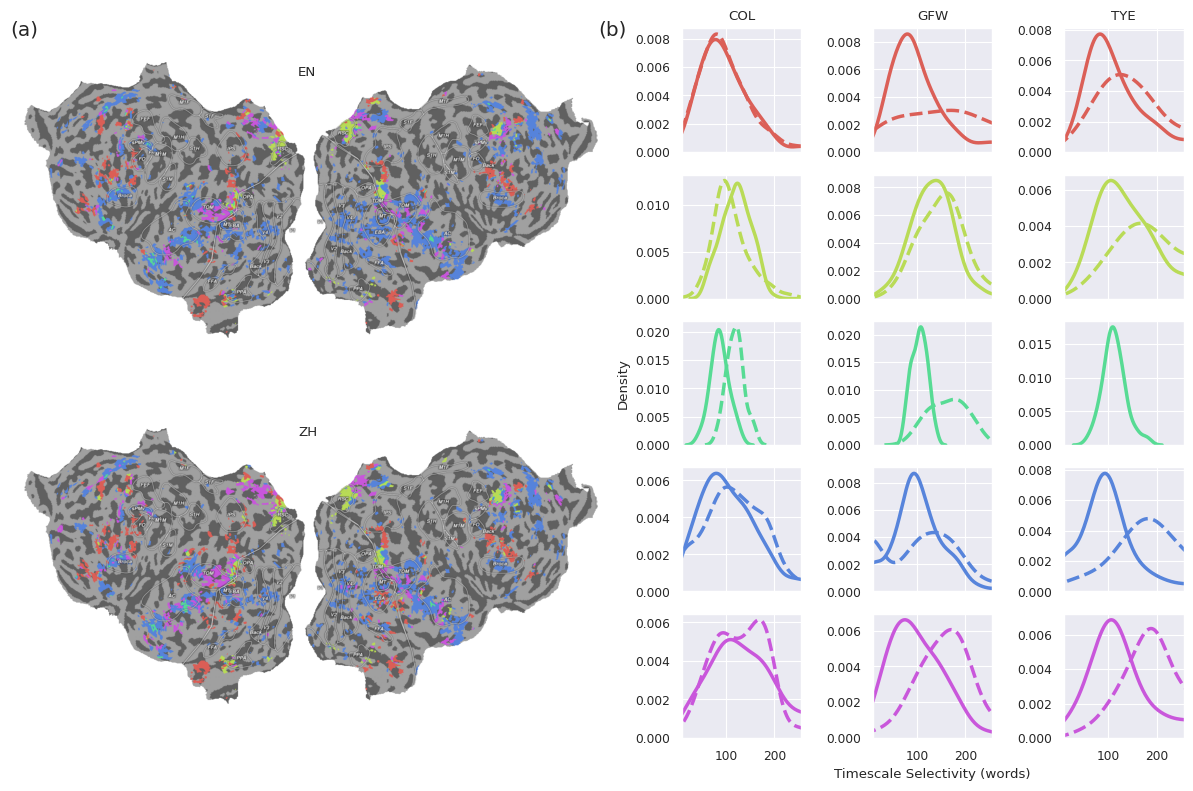

In [89]:
fig = plt.figure(figsize=figsize_dict['double'])

# gridspec
gs = fig.add_gridspec(10, 4, width_ratios=[1.0, 0.2, 0.2, 0.2])

ax_en_flatmap= fig.add_subplot(gs[:5, 0])
ax_zh_flatmap = fig.add_subplot(gs[5:, 0])

en_flatmap = plt.imread(os.path.join(image_dir, f"COL/en_cluster.png"))
zh_flatmap = plt.imread(os.path.join(image_dir, f"COL/zh_cluster.png"))

ax_en_flatmap.imshow(en_flatmap)
ax_zh_flatmap.imshow(zh_flatmap)


ax_en_flatmap.axis('off')
ax_zh_flatmap.axis('off')

# now second row for COL histogram, 
col_hist_axs = [fig.add_subplot(gs[i*2:(i+1)*2, 1]) for i in range(5)]
col_hist_axs = plot_histograms(timescales_per_clusters, 'COL', axs=col_hist_axs, plot_ylabel=True)

# now second row for GFW histogram,
gfw_hist_axs = [fig.add_subplot(gs[i*2:(i+1)*2, 2]) for i in range(5)]
gfw_hist_axs = plot_histograms(timescales_per_clusters, 'GFW', axs=gfw_hist_axs, plot_xlabel=True)

# now second row for TYE histogram,
tye_hist_axs = [fig.add_subplot(gs[i*2:(i+1)*2, 3]) for i in range(5)]
tye_hist_axs = plot_histograms(timescales_per_clusters, 'TYE', axs=tye_hist_axs)

# add (a) in the top left corner
fig.text(0.01, 0.95, "(a)", fontsize=default_font_size*1.5)

# add (b) in the the middle of the second row
fig.text(0.5, 0.95, "(b)", fontsize=default_font_size*1.5)


# add EN and ZH label
fig.text(0.25, 0.9, "EN", fontsize=default_font_size)
fig.text(0.25, 0.45, "ZH", fontsize=default_font_size)

plt.tight_layout()

fig_fn = os.path.join(image_dir, "timescale_cluster_agg.png")

plt.savefig(fig_fn, dpi=300, bbox_inches='tight')

plt.show()